# Introduction

In this workshop, we will go through the steps of training, debugging, deploying and monitoring a **network traffic classification model**.

For training our model we will be using datasets <a href="https://registry.opendata.aws/cse-cic-ids2018/">CSE-CIC-IDS2018</a> by CIC and ISCX which are used for security testing and malware prevention.
These datasets include a huge amount of raw network traffic logs, plus pre-processed data where network connections have been reconstructed and  relevant features have been extracted using CICFlowMeter, a tool that outputs network connection features as CSV files. Each record is classified as benign traffic, or it can be malicious traffic, with a total number of 15 classes.

Starting from this featurized dataset, we have executed additional pre-processing for the purpose of this lab:
<ul>
    <li>Encoded class labels</li>
    <li>Replaced invalid string attribute values generated by CICFlowMeter (e.g. inf and Infinity)</li>
    <li>Executed one hot encoding of discrete attributes</li>
    <li>Remove invalid headers logged multiple times in the same CSV file</li>
    <li>Reduced the size of the featurized dataset to ~1.3GB (from ~6.3GB) to speed-up training, while making sure that all classes are well represented</li>
    <li>Executed stratified random split of the dataset into training (80%) and validation (20%) sets</li>
</ul>

Class are represented and have been encoded as follows (train + validation):


| Label                    | Encoded | N. records |
|:-------------------------|:-------:|-----------:|
| Benign                   |    0    |    1000000 |
| Bot                      |    1    |     200000 |
| DoS attacks-GoldenEye    |    2    |      40000 |
| DoS attacks-Slowloris    |    3    |      10000 |
| DDoS attacks-LOIC-HTTP   |    4    |     300000 |
| Infilteration            |    5    |     150000 |
| DDOS attack-LOIC-UDP     |    6    |       1730 |
| DDOS attack-HOIC         |    7    |     300000 |
| Brute Force -Web         |    8    |        611 |
| Brute Force -XSS         |    9    |        230 |
| SQL Injection            |   10    |         87 |
| DoS attacks-SlowHTTPTest |   11    |     100000 |
| DoS attacks-Hulk         |   12    |     250000 |
| FTP-BruteForce           |   13    |     150000 |
| SSH-Bruteforce           |   14    |     150000 |       

The final pre-processed dataset has been saved to a public Amazon S3 bucket for your convenience, and will represent the inputs to the training processes.

### Let's get started!

First, we set some variables, including the AWS region we are working in, the IAM (Identity and Access Management) execution role of the notebook instance and the Amazon S3 bucket where we will store data, models, outputs, etc. We will use the Amazon SageMaker default bucket for the selected AWS region, and then define a key prefix to make sure all objects have share the same prefix for easier discoverability.

In [11]:
import os
import boto3
import sagemaker

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()
prefix = 'aim362'
os.environ["AWS_REGION"] = region

print(region)
print(role)
print(bucket_name)

us-east-1
arn:aws:iam::809744541236:role/service-role/AmazonSageMaker-ExecutionRole-20220203T135455
sagemaker-us-east-1-809744541236


Now we can copy the dataset from the public Amazon S3 bucket to the Amazon SageMaker default bucket used in this workshop. To do this, we will leverage on the AWS Python SDK (boto3) as follows:

In [12]:
import boto3

s3 = boto3.resource('s3')

source_bucket_name = "endtoendmlapp"
source_bucket_prefix = "aim362/data/"
source_bucket = s3.Bucket(source_bucket_name)

for s3_object in source_bucket.objects.filter(Prefix=source_bucket_prefix):
    copy_source = {
        'Bucket': source_bucket_name,
        'Key': s3_object.key
    }
    print('Copying {0} ...'.format(s3_object.key))
    s3.Bucket(bucket_name).copy(copy_source, s3_object.key)

Copying aim362/data/train/0.part ...
Copying aim362/data/train/1.part ...
Copying aim362/data/train/2.part ...
Copying aim362/data/train/3.part ...
Copying aim362/data/train/4.part ...
Copying aim362/data/train/5.part ...
Copying aim362/data/train/6.part ...
Copying aim362/data/train/7.part ...
Copying aim362/data/train/8.part ...
Copying aim362/data/train/9.part ...
Copying aim362/data/val/0.part ...
Copying aim362/data/val/1.part ...
Copying aim362/data/val/2.part ...
Copying aim362/data/val/3.part ...
Copying aim362/data/val/4.part ...
Copying aim362/data/val/5.part ...
Copying aim362/data/val/6.part ...
Copying aim362/data/val/7.part ...
Copying aim362/data/val/8.part ...
Copying aim362/data/val/9.part ...


Let's download some of the data to the notebook to quickly explore the dataset structure:

In [13]:
train_file_path = 's3://' + bucket_name + '/' + prefix + '/data/train/0.part'
val_file_path = 's3://' + bucket_name + '/' + prefix + '/data/val/0.part'

In [14]:
!mkdir -p data/train/ data/val/
!aws s3 cp {train_file_path} data/train/
!aws s3 cp {val_file_path} data/val/

download: s3://sagemaker-us-east-1-809744541236/aim362/data/train/0.part to data/train/0.part
download: s3://sagemaker-us-east-1-809744541236/aim362/data/val/0.part to data/val/0.part


In [15]:
import pandas as pd
pd.options.display.max_columns = 100

df = pd.read_csv('data/train/0.part')
df.head(10)

,Target,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,day,month,year,dayofweek,prot_0,prot_6,prot_17
0,0,445,64443,5,4,373,172,140,0,74.600000,70.283711,133,0,43.0,62.753486,8457.086107,139.658303,8.055375e+03,1.105582e+04,21474,3,64403,1.610075e+04,1.073215e+04,21537,3,64398,2.146600e+04,129.201393,21547,21317,0,0,0,0,112,92,77.587946,62.070357,0,140,54.500000,64.198044,4121.388889,0,0,0,1,0,0,0,0,0.0,60.555556,74.600000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,5,373,4,172,8192,0,3,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0
1,12,80,1527,2,0,0,0,0,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,1309.757695,1.527000e+03,0.000000e+00,1527,1527,1527,1.527000e+03,0.000000e+00,1527,1527,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,1309.757695,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
2,7,80,5573,2,0,0,0,0,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,358.873138,5.573000e+03,0.000000e+00,5573,5573,5573,5.573000e+03,0.000000e+00,5573,5573,0,0.000000e+00,0.000000,0,0,0,0,0,0,40,0,358.873138,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,32738,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,21,2,2018,2,0,1,0
3,12,80,44934,2,0,0,0,0,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,44.509725,4.493400e+04,0.000000e+00,44934,44934,44934,4.493400e+04,0.000000e+00,44934,44934,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,44.509725,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
4,0,443,60108569,4,2,148,252,74,0,37.000000,42.723920,126,126,126.0,0.000000,6.654625,0.099819,1.202171e+07,2.677679e+07,59921494,44882,60108569,2.003619e+07,3.454169e+07,59921494,93516,60013670,6.001367e+07,0.000000,60013670,60013670,1,0,0,0,80,40,0.066546,0.033273,0,126,67.714286,51.774235,2680.571429,0,1,0,0,1,0,0,0,0.0,79.000000,37.000000,126.0,0.0,0.0,0.0,0.0,0.0,0.0,4,148,2,252,257,7010,1,20,93559.0,0.0,93559,93559,59921494.0,0.0,59921494,59921494,20,2,2018,1,0,1,0
5,4,80,1417674,3,4,20,964,20,0,6.666667,11.547005,964,0,241.0,482.000000,694.094693,4.937665,2.362790e+05,5.785577e+05,1417255,4,397,1.985000e+02,2.269813e+02,359,38,1417670,4.725567e+05,818132.777500,1417255,18,0,0,0,0,72,92,2.116142,2.821523,0,964,123.000000,339.887376,115523.428600,0,0,1,1,0,0,0,1,1.0,140.571429,6.666667,241.0,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0
6,7,80,22011,2,0,0,0,0,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,90.863659,2.201100e+04,0.000000e+00,22011,22011,22011,2.201100e+04,0.000000e+00,22011,22011,0,0.000000e+00,0.000000,0,0,0,0,0,0,40,0,90.863659,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,32738,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,21,2,2018,2,0,1,0
7,3,80,116030775,2,2,16,0,8,8,8.000000,0.0000

# Training and Debugging

The network traffic classification model will be trained using the Amazon SageMaker framework container for XGBoost (https://github.com/aws/sagemaker-xgboost-container). Using XGBoost as a framework provides more flexibility than using it as a built-in algorithm as it enables more advanced scenarios that allow pre-processing and post-processing scripts or any kind of custom logic to be incorporated into your training script.

First, we will execute basic training to make sure our training script works as expected and we are able to fit the model successfully, and then we will go through the steps for enabling debugging using Amazon SageMaker Debugger.

## Basic Training

We will execute the training script in local mode while building our model: local mode is a functionality enabled by the Amazon SageMaker Python SDK that allows running the same training code and container that will be used in Amazon SageMaker locally on the notebook instance, in order to speed-up experimentation and quickly fix errors before running training with Amazon SageMaker training.

For local mode training, we can re-use the training and validation files downloaded on the notebook instance in the previous steps, as local file inputs.

Let's take a look at our training script.

In [16]:
!pygmentize source_dir/train_xgboost_no_debug.py

import argparse
import json
import os
import random
import pandas as pd
import glob
import pickle as pkl

import xgboost

def parse_args():

    parser = argparse.ArgumentParser()

    parser.add_argument("--max_depth", type=int, default=5)
    parser.add_argument("--eta", type=float, default=0.05)  # 0.2
    parser.add_argument("--gamma", type=int, default=4)
    parser.add_argument("--min_child_weight", type=int, default=6)
    parser.add_argument("--silent", type=int, default=0)
    parser.add_argument("--objective", type=str, default="multi:softmax")
    parser.add_argument("--num_class", type=int, default=15)
    parser.add_argument("--num_round", type=int, default=10)
    
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))

    args = parser.parse_args()

    return args

def model_fn(model_dir):
    model_file = model_dir + '/model.bin'
    mod

The script parses arguments that are passed when the XGBoost Docker container code invokes the script for execution. These arguments represent the hyperparameters that you specify when strarting the training job plus the location of training and validation data; this behavior, named Script Mode execution, is enabled by a library that is installed in the XGBoost container (sagemaker-containers, https://github.com/aws/sagemaker-containers) and facilitates the development of SageMaker-compatible Docker containers.

Then, we load training and validation data and execute XGBoost training with the provided parameters.

Once we have our script ready, we can leverage on the XGBoost estimator of the Amazon SageMaker Python SDK to start training locally.

In [17]:
from sagemaker.xgboost import XGBoost

hyperparameters = {
    "max_depth": "3",
    "eta": "0.1",
    "gamma": "6",
    "min_child_weight": "6",
    "silent": "0",
    "objective": "multi:softmax",
    "num_class": "15",
    "num_round": "10"
}

entry_point='train_xgboost_no_debug.py'
source_dir='source_dir/'
output_path = 's3://{0}/{1}/output/'.format(bucket_name, prefix)
code_location = 's3://{0}/{1}/code'.format(bucket_name, prefix)

estimator = XGBoost(
    base_job_name="nw-traffic-classification-xgb",
    entry_point=entry_point,
    source_dir=source_dir,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    instance_type="local", # Specifying local as instance type to run local-mode training
    instance_count=1,
    framework_version="0.90-2",
    py_version="py3",
    role=role
)

train_config = 'file://data/train/'
val_config = 'file://data/val/'

estimator.fit({'train': train_config, 'validation': val_config })

Creating m4ta62rwfj-algo-1-rx96l ... 
Creating m4ta62rwfj-algo-1-rx96l ... done
Attaching to m4ta62rwfj-algo-1-rx96l
m4ta62rwfj-algo-1-rx96l | INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
m4ta62rwfj-algo-1-rx96l | INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
m4ta62rwfj-algo-1-rx96l | INFO:sagemaker_xgboost_container.training:Invoking user training script.
m4ta62rwfj-algo-1-rx96l | INFO:sagemaker-containers:Module train_xgboost_no_debug does not provide a setup.py. 
m4ta62rwfj-algo-1-rx96l | Generating setup.py
m4ta62rwfj-algo-1-rx96l | INFO:sagemaker-containers:Generating setup.cfg
m4ta62rwfj-algo-1-rx96l | INFO:sagemaker-containers:Generating MANIFEST.in
m4ta62rwfj-algo-1-rx96l | INFO:sagemaker-containers:Installing module with the following command:
m4ta62rwfj-algo-1-rx96l | /miniconda3/bin/python3 -m pip install . 
m4ta62rwfj-algo-1-rx96l | Processing /opt/ml/code
m4ta62rwfj-algo-1-rx96l | Building wheels for collected

In order to make sure that our code works for inference, we can deploy the trained model locally and execute some inferences.

In [18]:
predictor = estimator.deploy(initial_instance_count=1,
                            instance_type='local') # Using local-mode deployment

Attaching to rsvqsuh12l-algo-1-1g9v5
rsvqsuh12l-algo-1-1g9v5 | [2022-02-03:23:01:51:INFO] No GPUs detected (normal if no gpus installed)
rsvqsuh12l-algo-1-1g9v5 | [2022-02-03:23:01:51:INFO] No GPUs detected (normal if no gpus installed)
rsvqsuh12l-algo-1-1g9v5 | [2022-02-03:23:01:51:INFO] nginx config: 
rsvqsuh12l-algo-1-1g9v5 | worker_processes auto;
rsvqsuh12l-algo-1-1g9v5 | daemon off;
rsvqsuh12l-algo-1-1g9v5 | pid /tmp/nginx.pid;
rsvqsuh12l-algo-1-1g9v5 | error_log  /dev/stderr;
rsvqsuh12l-algo-1-1g9v5 | 
rsvqsuh12l-algo-1-1g9v5 | worker_rlimit_nofile 4096;
rsvqsuh12l-algo-1-1g9v5 | 
rsvqsuh12l-algo-1-1g9v5 | events {
rsvqsuh12l-algo-1-1g9v5 |   worker_connections 2048;
rsvqsuh12l-algo-1-1g9v5 | }
rsvqsuh12l-algo-1-1g9v5 | 
rsvqsuh12l-algo-1-1g9v5 | http {
rsvqsuh12l-algo-1-1g9v5 |   include /etc/nginx/mime.types;
rsvqsuh12l-algo-1-1g9v5 |   default_type application/octet-stream;
rsvqsuh12l-algo-1-1g9v5 |   access_log /dev/stdout combined;
rsvqsuh12l-algo-1-1g9v5 | 
rsvqsuh12l-algo

In [19]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sagemaker.predictor import RealTimePredictor

#predictor.content_type = 'text/csv'
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

# We expect 4 - DDoS attacks-LOIC-HTTP as the predicted class for this instance.
test_values = [80,1056736,3,4,20,964,20,0,6.666666667,11.54700538,964,0,241.0,482.0,931.1691850999999,6.6241710320000005,176122.6667,431204.4454,1056315,2,394,197.0,275.77164469999997,392,2,1056733,352244.3333,609743.1115,1056315,24,0,0,0,0,72,92,2.8389304419999997,3.78524059,0,964,123.0,339.8873763,115523.4286,0,0,1,1,0,0,0,1,1.0,140.5714286,6.666666667,241.0,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0]
result = predictor.predict(test_values)
print(result)

rsvqsuh12l-algo-1-1g9v5 | [2022-02-03:23:01:59:INFO] Determined delimiter of CSV input is ','
rsvqsuh12l-algo-1-1g9v5 | 172.18.0.1 - - [03/Feb/2022:23:01:59 +0000] "POST /invocations HTTP/1.1" 200 5 "-" "python-urllib3/1.26.7"
[4.0]


Finally, let's gracefully stop the deployed local endpoint.

In [20]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


#### Results
During training, we have seen that both the train-merror and validation-merror are decreasing, although we don't have details on the accuracy per-class (we will address this later). We have also successfully deployed the model to a local endpoint and executed inferences.

## Debugging

### LossNotDecreasing

Once we are confident our training script is working as expected and there are no major errors preventing its execution, we can enable debugging.

During training, we will save the state of the tensors using Amazon SageMaker debugging features, and then analyze debugging outputs with jobs that are run while the training job is executed. For XGBoost, Amazon SageMaker debugging supports saving evaluation metrics, lebels and predictions, feature importances, and SHAP values.

First, we need to modify our training script to enable Amazon SageMaker debugging. Note that this is required for the XGBoost framework, whilst for MXNet and Tensorflow debugging works also with no code changes.

We created a Hook object which we pass as a callback function when creating a Booster. The Hook object is created by loading a JSON configuration that is available in a specific path in the Docker container (opt/ml/input/config/debughookconfig.json); this file is generated by Amazon SageMaker from the CreateTrainingJob() API call configuration. Note that Amazon SageMaker debugging is highly configurable, you can choose exactly what to save.

Let's look at the modified script:

In [21]:
!pygmentize source_dir/train_xgboost.py

import argparse
import bz2
import json
import os
import pickle
import random
import tempfile
import urllib.request
import pandas as pd
import glob
import pickle as pkl

import xgboost

from smdebug import SaveConfig
from smdebug.xgboost import Hook

def parse_args():

    parser = argparse.ArgumentParser()

    parser.add_argument("--max_depth", type=int, default=5)
    parser.add_argument("--eta", type=float, default=0.05)  # 0.2
    parser.add_argument("--gamma", type=int, default=4)
    parser.add_argument("--min_child_weight", type=int, default=6)
    parser.add_argument("--silent", type=int, default=0)
    parser.add_argument("--objective", type=str, default="multi:softmax")
    parser.add_argument("--num_class", type=int, default=15)
    parser.add_argument("--num_round", type=int, default=10)

    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))


The modified script allows to **capture tensors** and **save to Amazon S3**, but doing this will not cause any debug analysis to run. In order to analyze debug outputs we need to configure the XGBoost estimator to define **a collection of rules that will be run while the training job is executed**.

We are enabling a built-in (1P) debug rule named **LossNotDecreasing** which checks if the loss is not decreasing across step. In this scenario, we have chosen to run this rule at every step on the validation-merror metric values: this means that the new merror values must always go down at each step.

When the estimator fit() method is called, Amazon SageMaker will start two jobs: a **Training Job**, where we also capture and save tensors, and a debug **Processing Job** (powered by **Amazon SageMaker Processing Jobs**), which will run in parallel and analyze tensor data to check if the rule conditions are met.

Note that we are passing the **Wait=False** parameter to the fit() method to avoid waiting for the training job to  complete and just fire and forget the API call.

In [22]:
from sagemaker.xgboost import XGBoost
from sagemaker.debugger import Rule, rule_configs, DebuggerHookConfig, CollectionConfig

hyperparameters = {
    "max_depth": "10",
    "eta": "0.2",
    "gamma": "1",
    "min_child_weight": "6",
    "silent": "0",
    "objective": "multi:softmax",
    "num_class": "15",
    "num_round": "20"
}

entry_point='train_xgboost.py'
source_dir='source_dir/'
output_path = 's3://{0}/{1}/output/'.format(bucket_name, prefix)
debugger_output_path = 's3://{0}/{1}/output/debug'.format(bucket_name, prefix) # Path where we save debug outputs
code_location = 's3://{0}/{1}/code'.format(bucket_name, prefix)

hook_config = DebuggerHookConfig(
    s3_output_path=debugger_output_path,
    hook_parameters={
        "save_interval": "1"
    },
    collection_configs=[
        CollectionConfig("hyperparameters"),
        CollectionConfig("metrics"),
        CollectionConfig("predictions"),
        CollectionConfig("labels"),
        CollectionConfig("feature_importance")
    ]
)

estimator = XGBoost(
    base_job_name="nw-traffic-classification-xgb",
    entry_point=entry_point,
    source_dir=source_dir,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    instance_type="ml.m5.4xlarge",
    instance_count=1,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
    
    # Initialize your hook.
    debugger_hook_config=hook_config,
    
    # Initialize your rules. These will read data for analyses from the path specified
    # for the hook
    rules=[Rule.sagemaker(rule_configs.loss_not_decreasing(),
                         rule_parameters={
                             # Rule does not use the default losses collection,
                             # but uses a regex to look for specific tensor values
                             "use_losses_collection": "False",
                             "tensor_regex": "validation-merror",
                             # Num steps is used to specify when to evaluate this rule (every num_steps)
                             "num_steps" : "1"}
                         )]
)

train_config = sagemaker.inputs.TrainingInput('s3://{0}/{1}/data/train/'.format(
    bucket_name, prefix), content_type='text/csv')
val_config = sagemaker.inputs.TrainingInput('s3://{0}/{1}/data/val/'.format(
    bucket_name, prefix), content_type='text/csv')

estimator.fit({'train': train_config, 'validation': val_config }, wait=False)

Once the training job has started, we can check its debug configuration and status:

In [23]:
import time
client = estimator.sagemaker_session.sagemaker_client

description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print('Debug Hook configuration: ')
print(description['DebugHookConfig'])
print()
print('Debug rules configuration: ')
print(description['DebugRuleConfigurations'])
print()
print('Training job status')
print(description['TrainingJobStatus'])

Debug Hook configuration: 
{'S3OutputPath': 's3://sagemaker-us-east-1-809744541236/aim362/output/debug', 'HookParameters': {'save_interval': '1'}, 'CollectionConfigurations': [{'CollectionName': 'labels'}, {'CollectionName': 'feature_importance'}, {'CollectionName': 'metrics'}, {'CollectionName': 'losses', 'CollectionParameters': {'save_interval': '500'}}, {'CollectionName': 'hyperparameters'}, {'CollectionName': 'predictions'}]}

Debug rules configuration: 
[{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluatorImage': '503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', 'VolumeSizeInGB': 0, 'RuleParameters': {'num_steps': '1', 'rule_to_invoke': 'LossNotDecreasing', 'tensor_regex': 'validation-merror', 'use_losses_collection': 'False'}}]

Training job status
InProgress


We can also get all the logs for the training job being executed:

In [24]:
sagemaker_session.logs_for_job(estimator.latest_training_job.name)

2022-02-03 23:02:01 Starting - Starting the training job.

At the same time, we can check the status of the rule execution job as follows. Note that this requires some time, so you might be interested in looking at the SageMaker Debugger documentation while this runs: https://github.com/awslabs/sagemaker-debugger.

In [25]:
import time

client = estimator.sagemaker_session.sagemaker_client

iterate = True
while(iterate):
    description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
    eval_status = description['DebugRuleEvaluationStatuses'][0]
    print(eval_status)
    if eval_status['RuleEvaluationStatus'] != 'InProgress':
        iterate = False
    else:
        time.sleep(60)

{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluationStatus': 'InProgress', 'LastModifiedTime': datetime.datetime(2022, 2, 3, 23, 2, 1, 907000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:809744541236:processing-job/nw-traffic-classification--lossnotdecreasing-c9bdc332', 'RuleEvaluationStatus': 'InProgress', 'LastModifiedTime': datetime.datetime(2022, 2, 3, 23, 2, 49, 251000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:809744541236:processing-job/nw-traffic-classification--lossnotdecreasing-c9bdc332', 'RuleEvaluationStatus': 'InProgress', 'LastModifiedTime': datetime.datetime(2022, 2, 3, 23, 3, 49, 493000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:809744541236:processing-job/nw-traffic-classification--lossnotdecreasing-c9bdc332', 'RuleEvaluationStatus': 

The rule execution job raised an error since the rule evaluation condition is met. Let's review the configuration and logs of the rule execution job, executed by Amazon SageMaker Processing Jobs:

In [26]:
processing_job_arn = eval_status['RuleEvaluationJobArn']
processing_job_name = processing_job_arn[processing_job_arn.rfind('/') + 1 :]
print(processing_job_name)

client = estimator.sagemaker_session.sagemaker_client
descr = client.describe_processing_job(ProcessingJobName=processing_job_name)
descr

nw-traffic-classification--lossnotdecreasing-c9bdc332


{'ProcessingInputs': [{'InputName': 'Tensors',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-809744541236/aim362/output/debug/nw-traffic-classification-xgb-2022-02-03-23-02-01-238/debug-output',
    'LocalPath': '/opt/ml/processing/input/tensors',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'RuleOutput',
    'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-809744541236/aim362/output/nw-traffic-classification-xgb-2022-02-03-23-02-01-238/rule-output/LossNotDecreasing',
     'LocalPath': '/opt/ml/processing/output/rule',
     'S3UploadMode': 'Continuous'},
    'AppManaged': False}]},
 'ProcessingJobName': 'nw-traffic-classification--LossNotDecreasing-c9bdc332',
 'ProcessingResources': {'ClusterConfig': {'InstanceCount': 1,
   'InstanceType': 'ml.t3.medium',
   'VolumeSizeInGB': 30}},
 'StoppingCondition': {'MaxR

In [27]:
sagemaker_session.logs_for_processing_job(descr['ProcessingJobName'])

[2022-02-03 23:10:24.203 ip-10-2-81-114.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-03 23:10:26.717 ip-10-2-81-114.ec2.internal:1 INFO local_trial.py:35] Loading trial base_trial at path /opt/ml/processing/input/tensors
No environment variable found with name "base_trial". Will use default param value if present
No environment variable found with name "collection_names". Will use default param value if present
No environment variable found with name "diff_percent". Will use default param value if present
No environment variable found with name "increase_threshold_percent". Will use default param value if present
No environment variable found with name "mode". Will use default param value if present
No environment variable found with name "absolute_val". Will use default param value if present
No environment variable found with name "action_json". Will use default param value if present
[2022-02-03 23:10:26.894 ip-10-2-81-114.ec2.internal:1 INFO action.

#### Results
We can see that the condition is being met at step 7 when validation-merror is not decreasing. When this happens, we might be interested in stopping training earlier. You can also leverage on Amazon CloudWatch Events to detect the rule condition met event and take specific actions automatically. 

### Debugging - Confusion

As another example of using a first party (1P) rule provided by Amazon SageMaker debugging, let us again train and use a 1P rule `Confusion` to monitor the training job in realtime.

During training, `Confusion` Rule job will monitor whether you are running into a situation where the ratio of on-diagonal and off-diagonal values in the confusion matrix is not within a specified range. In other words, this rule evaluates the goodness of a confusion matrix for a classification problem. It creates a matrix of size `category_no` $\times$ `category_no` and populates it with data coming from (`y`, `y_hat`) pairs. For each (`y`, `y_hat`) pairs the count in `confusion[y][y_hat]` is  incremented by 1. Once the matrix is fully populated, the ratio of data on- and off-diagonal will be evaluated according to:

- For elements on the diagonal:

$$ \frac{ \text{confusion}_{ii} }{ \sum_j \text{confusion}_{jj} } \geq \text{min_diag} $$

- For elements off the diagonal:

$$ \frac{ \text{confusion}_{ji} }{ \sum_j \text{confusion}_{ji} } \leq \text{max_off_diag} $$

Please note that in this case we are setting the `start_step` and `end_step` rule parameters, to make sure the rule is evaluated only during the latest steps.

In [28]:
from sagemaker.xgboost import XGBoost
from sagemaker.debugger import Rule, rule_configs, DebuggerHookConfig

hyperparameters = {
    "max_depth": "10",
    "eta": "0.2",
    "gamma": "1",
    "min_child_weight": "6",
    "silent": "0",
    "objective": "multi:softmax",
    "num_class": "15",
    "num_round": "20"
}

entry_point='train_xgboost.py'
source_dir='source_dir/'
output_path = 's3://{0}/{1}/output/'.format(bucket_name, prefix)
debugger_output_path = 's3://{0}/{1}/output/debug'.format(bucket_name, prefix)
code_location = 's3://{0}/{1}/code'.format(bucket_name, prefix)

hook_config = DebuggerHookConfig(
    s3_output_path=debugger_output_path,
    hook_parameters={
        "save_interval": "1"
    },
    collection_configs=[
        CollectionConfig("hyperparameters"),
        CollectionConfig("metrics"),
        CollectionConfig("predictions"),
        CollectionConfig("labels"),
        CollectionConfig("feature_importance")
    ]
)

estimator = XGBoost(
    base_job_name="nw-traffic-classification-xgb",
    entry_point=entry_point,
    source_dir=source_dir,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    instance_type="ml.m5.4xlarge",
    instance_count=1,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
    
    # Initialize your hook.
    debugger_hook_config=hook_config,
    
    # Initialize your rules. These will read data for analyses from the path specified
    # for the hook
    rules=[Rule.sagemaker(rule_configs.confusion(),
                             rule_parameters={
                                 "category_no": "15",
                                 "min_diag": "0.7",
                                 "max_off_diag": "0.3",
                                 "start_step": "17",
                                 "end_step": "19"}
                         )]
)

train_config = sagemaker.inputs.TrainingInput('s3://{0}/{1}/data/train/'.format(
    bucket_name, prefix), content_type='text/csv')
val_config = sagemaker.inputs.TrainingInput('s3://{0}/{1}/data/val/'.format(
    bucket_name, prefix), content_type='text/csv')

estimator.fit({'train': train_config, 'validation': val_config }, wait=False)

Agan, let's review the training job status, configuration and logs:

In [29]:
import time
client = estimator.sagemaker_session.sagemaker_client

description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print('Debug Hook configuration: ')
print(description['DebugHookConfig'])
print()
print('Debug rules configuration: ')
print(description['DebugRuleConfigurations'])
print()
print('Training job status')
print(description['TrainingJobStatus'])

Debug Hook configuration: 
{'S3OutputPath': 's3://sagemaker-us-east-1-809744541236/aim362/output/debug', 'HookParameters': {'save_interval': '1'}, 'CollectionConfigurations': [{'CollectionName': 'labels'}, {'CollectionName': 'feature_importance'}, {'CollectionName': 'metrics'}, {'CollectionName': 'hyperparameters'}, {'CollectionName': 'predictions'}]}

Debug rules configuration: 
[{'RuleConfigurationName': 'Confusion', 'RuleEvaluatorImage': '503895931360.dkr.ecr.us-east-1.amazonaws.com/sagemaker-debugger-rules:latest', 'VolumeSizeInGB': 0, 'RuleParameters': {'category_no': '15', 'end_step': '19', 'max_off_diag': '0.3', 'min_diag': '0.7', 'rule_to_invoke': 'Confusion', 'start_step': '17'}}]

Training job status
InProgress


In [30]:
sagemaker_session.logs_for_job(estimator.latest_training_job.name)

2022-02-03 23:13:48 Starting - Preparing the instances for training.

Then, we can wait for the rule execution to complete:

In [31]:
import time

client = estimator.sagemaker_session.sagemaker_client

iterate = True
while(iterate):
    description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
    eval_status = description['DebugRuleEvaluationStatuses'][0]
    print(eval_status)
    if eval_status['RuleEvaluationStatus'] != 'InProgress':
        iterate = False
    else:
        time.sleep(60)

{'RuleConfigurationName': 'Confusion', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:809744541236:processing-job/nw-traffic-classification--confusion-41322f71', 'RuleEvaluationStatus': 'InProgress', 'LastModifiedTime': datetime.datetime(2022, 2, 3, 23, 19, 29, 72000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'Confusion', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:809744541236:processing-job/nw-traffic-classification--confusion-41322f71', 'RuleEvaluationStatus': 'InProgress', 'LastModifiedTime': datetime.datetime(2022, 2, 3, 23, 20, 29, 284000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'Confusion', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:809744541236:processing-job/nw-traffic-classification--confusion-41322f71', 'RuleEvaluationStatus': 'InProgress', 'LastModifiedTime': datetime.datetime(2022, 2, 3, 23, 21, 29, 511000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'Confusion', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:809744541236:processing-

Let's review the rule execution job, executed by Amazon SageMaker Processing:

In [32]:
processing_job_arn = eval_status['RuleEvaluationJobArn']
processing_job_name = processing_job_arn[processing_job_arn.rfind('/') + 1 :]
print(processing_job_name)

client = estimator.sagemaker_session.sagemaker_client
descr = client.describe_processing_job(ProcessingJobName=processing_job_name)
descr

nw-traffic-classification--confusion-41322f71


{'ProcessingInputs': [{'InputName': 'Tensors',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-809744541236/aim362/output/debug/nw-traffic-classification-xgb-2022-02-03-23-12-01-129/debug-output',
    'LocalPath': '/opt/ml/processing/input/tensors',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'RuleOutput',
    'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-809744541236/aim362/output/nw-traffic-classification-xgb-2022-02-03-23-12-01-129/rule-output/Confusion',
     'LocalPath': '/opt/ml/processing/output/rule',
     'S3UploadMode': 'Continuous'},
    'AppManaged': False}]},
 'ProcessingJobName': 'nw-traffic-classification--Confusion-41322f71',
 'ProcessingResources': {'ClusterConfig': {'InstanceCount': 1,
   'InstanceType': 'ml.t3.medium',
   'VolumeSizeInGB': 30}},
 'StoppingCondition': {'MaxRuntimeInSeconds'

In [33]:
sagemaker_session.logs_for_processing_job(descr['ProcessingJobName'])

[2022-02-03 23:20:24.467 ip-10-0-164-126.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-03 23:20:26.845 ip-10-0-164-126.ec2.internal:1 INFO trial.py:113] Trial base_trial will look for steps between 17 and 19
[2022-02-03 23:20:26.845 ip-10-0-164-126.ec2.internal:1 INFO local_trial.py:35] Loading trial base_trial at path /opt/ml/processing/input/tensors
No environment variable found with name "base_trial". Will use default param value if present
No environment variable found with name "labels". Will use default param value if present
No environment variable found with name "predictions". Will use default param value if present
No environment variable found with name "labels_collection_name". Will use default param value if present
No environment variable found with name "predictions_collection_name". Will use default param value if present
No environment variable found with name "violation_limit". Will use default param value if present
No environment vari

Let's also make sure the training job is completed.

In [34]:
import time

client = estimator.sagemaker_session.sagemaker_client

iterate = True
while(iterate):
    description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
    training_job_status = description['TrainingJobStatus']
    print(training_job_status)
    if training_job_status != 'InProgress':
        iterate = False
    else:
        time.sleep(60)

Completed


#### Results
We can see that the condition is being met and this gives evidences that our confusion matrix is not matching our thresholds.
Let's review the confusion matrix by analyzing the debug outputs in next section.

## Analyzing Debug Outputs

In this section we will see how you can use the SDK to manually analyze debug outputs.

First thing is creating a trial, which is the construct that allows accessing to tensors for a single training run.

In [35]:
!pip install smdebug

In [36]:
from smdebug.trials import create_trial

s3_output_path = description["DebugHookConfig"]["S3OutputPath"] + '/' + estimator.latest_training_job.name + '/debug-output/'
print(s3_output_path)
trial = create_trial(s3_output_path)

[2022-02-03 23:52:07.594 ip-172-16-60-41:11426 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
s3://sagemaker-us-east-1-809744541236/aim362/output/debug/nw-traffic-classification-xgb-2022-02-03-23-12-01-129/debug-output/
[2022-02-03 23:52:07.647 ip-172-16-60-41:11426 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-809744541236/aim362/output/debug/nw-traffic-classification-xgb-2022-02-03-23-12-01-129/debug-output/


Now we can print the list of all the tensors that were saved.

In [37]:
trial.tensor_names()

[2022-02-03 23:52:10.886 ip-172-16-60-41:11426 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-03 23:52:11.906 ip-172-16-60-41:11426 INFO trial.py:210] Loaded all steps


['feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f13',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f16',
 'feature_importance/cover/f17',
 'feature_importance/cover/f18',
 'feature_importance/cover/f19',
 'feature_importance/cover/f2',
 'feature_importance/cover/f20',
 'feature_importance/cover/f21',
 'feature_importance/cover/f22',
 'feature_importance/cover/f23',
 'feature_importance/cover/f24',
 'feature_importance/cover/f25',
 'feature_importance/cover/f26',
 'feature_importance/cover/f27',
 'feature_importance/cover/f28',
 'feature_importance/cover/f29',
 'feature_importance/cover/f3',
 'feature_importance/cover/f30',
 'feature_importance/cover/f32',
 'feature_importance/cover/f34',
 'feature_importance/cover/f35',
 'feature_importance/cover/f36',
 'feature_importance/cover/f37',
 'feature_impo

Given a specific tensor, we can ask at which steps we have data for the tensor. In this case, we have data for all steps since the frequency was set to 1.

In [38]:
trial.tensor("validation-merror").steps()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

We can also get the value of a specific tensor for a specific step as numpy.array

In [39]:
trial.tensor("train-merror").value(5)

array([0.018894])

### Performance metrics

We can also create a simple function that visualizes the training and validation errors as the training progresses. We expect each training errors to get smaller over time, as the system converges to a good solution. Now, remember that this is an interactive analysis - we are showing these tensors to give an idea of the data.

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function that, for the given tensor name, walks through all 
# the iterations for which we have data and fetches the value.
# Returns the set of steps and the values
def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

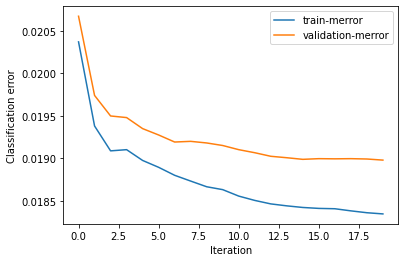

In [41]:
metrics_to_plot = ["train-merror", "validation-merror"]
for metric in metrics_to_plot:
    steps, data = get_data(trial, metric)
    plt.plot(steps, data, label=metric)
plt.xlabel('Iteration')
plt.ylabel('Classification error')
plt.legend()
plt.show()

### Feature importance

We can also visualize the feature importances as determined by xgboost.get_fscore(). Note that feature importances with zero values are not included here (which means that those features were not used in any split conditions).

For more information on the metrics related to feature importance in XGBoost, please visit: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

`weight` is the number of times a feature is used to split the data across all trees <br />
`gain` represents fractional contribution of each feature to the model based on the total gain of this feature's splits. Higher percentage means a more important predictive feature <br />
`cover` is a metric of the number of observation related to this feature <br />
`total_gain` is the total gain across all splits the feature is used in <br />
`total_cover` is the total coverage across all splits the feature is used in <br />

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
    
def plot_feature_importance(trial, collection_name, step, metric):
    feature_importance_tensors = trial.collection(collection_name).tensor_names

    feature_names = []
    feature_values = []
    
    plt.subplots(figsize=(18,7))
    
    for tensor_name in feature_importance_tensors:
        if tensor_name.find('/' + metric) >= 0:
            index = tensor_name.rfind('/')
            feature_name = tensor_name[index+1:]
            feature_names.append(feature_name)
            tensor = trial.tensor(tensor_name)
            value_at_step = tensor.value(step)[0]
            feature_values.append(value_at_step)

    pos = range(len(feature_values))
    plt.bar(pos, feature_values, color='g')
    plt.xlabel('Features', fontsize=16)
    plt.ylabel('Feature Importance ({0})'.format(metric), fontsize=16)
    plt.xticks(pos, feature_names)
    plt.show()
    

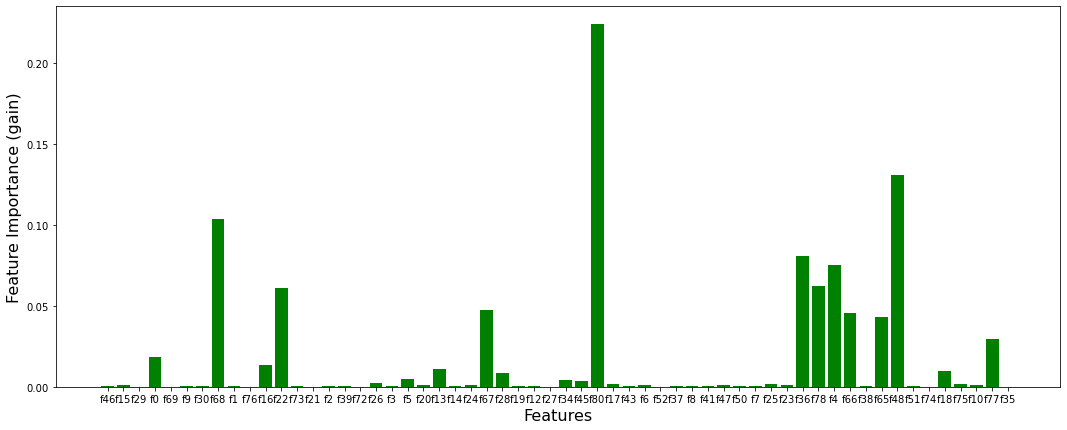

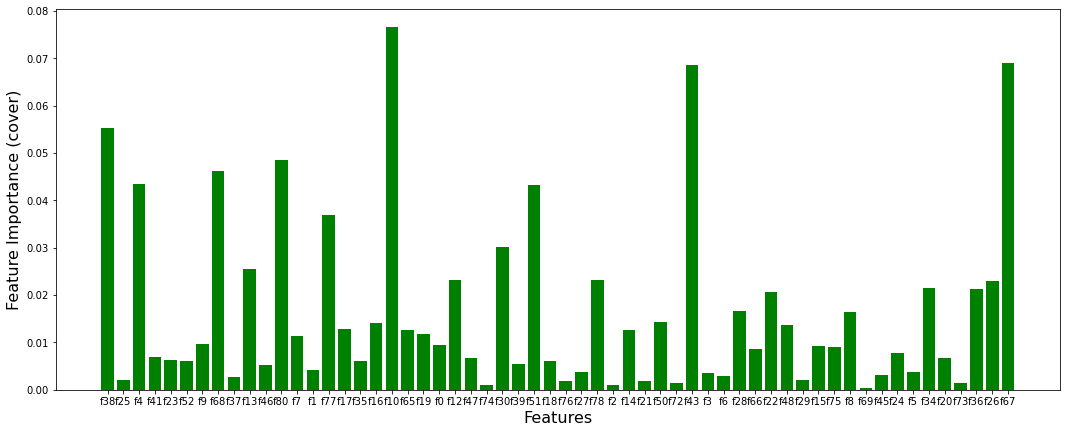

In [43]:
plot_feature_importance(trial, "feature_importance", 19, "gain")
plot_feature_importance(trial, "feature_importance", 19, "cover")

### Confusion Matrix

Finally, since we were logging labels and predictions, we can visualize the confusion matrix of the last step.

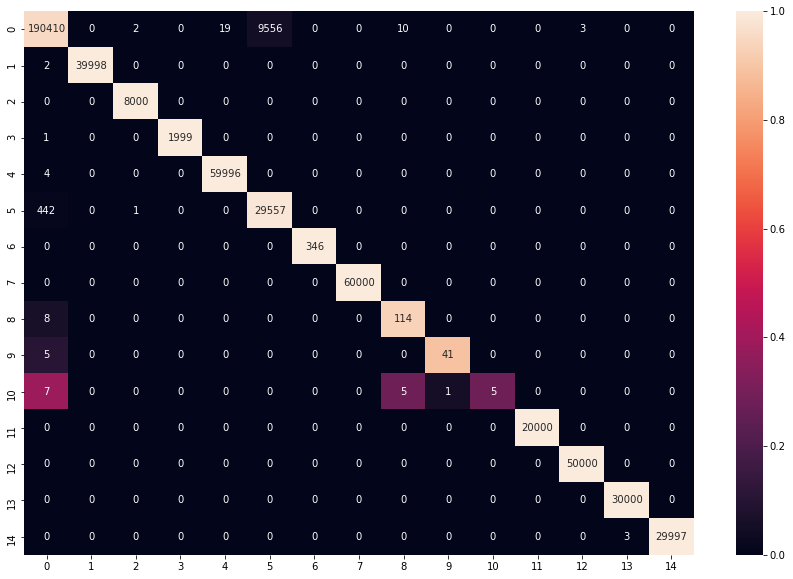

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from IPython.display import display, clear_output

fig, ax = plt.subplots(figsize=(15,10))
step = 19

cm = confusion_matrix(
    trial.tensor('labels').value(step),
    trial.tensor('predictions').value(step)
)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='')
plt.show()

You can now move to <a href="../02_deploy_and_monitor/deploy_and_monitor.ipynb">Deploy and Monitor</a> to see how to deploy this model and monitor its inference performance over time using Amazon SageMaker Model Monitor.

## References

A Realistic Cyber Defense Dataset (CSE-CIC-IDS2018) https://registry.opendata.aws/cse-cic-ids2018/